In [ ]:
using FileIO
using Plots
include("splitcell.jl")
include("segmentation3d.jl")
include("lineage.jl")
include("normalization3d.jl")
include("tiffxml.jl")

In [ ]:
@time d16s1 = load(File(format"TIFF", "../mRNA_confocal_hamamatsu-60X-TIRF/20200316/HE7-11-1-80uw-PWM_1_s1.ome.tiff"));

In [ ]:
@time mask_markers  = split_cell_LoG(d16s1, 138);

In [ ]:
@time time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1 = find_time_line(mask_markers);
println(longlived_labels_1);
#plot(sum.(livingtime_1), marker=:circle)

In [ ]:
@time split_contacted_cell!(time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1);

In [ ]:
@time tracks = walking(time_line_1, longlived_labels_1, livingtime_1);

In [ ]:
@time d16s1_longlived_maps, watershed_maps = grant_domain(d16s1, time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1);

In [10]:
@time cell_2 = pick_cell(d16s1, d16s1_longlived_maps, longlived_labels_1[3], tracks[:,:,3], livingtime_1[4]);

 36.310772 seconds (62.92 M allocations: 12.895 GiB, 6.28% gc time)


In [ ]:
@time cell_2 = pick_cell(d16s1, d16s1_longlived_maps, longlived_labels_1[3], tracks[:,:,3], livingtime_1[3]);

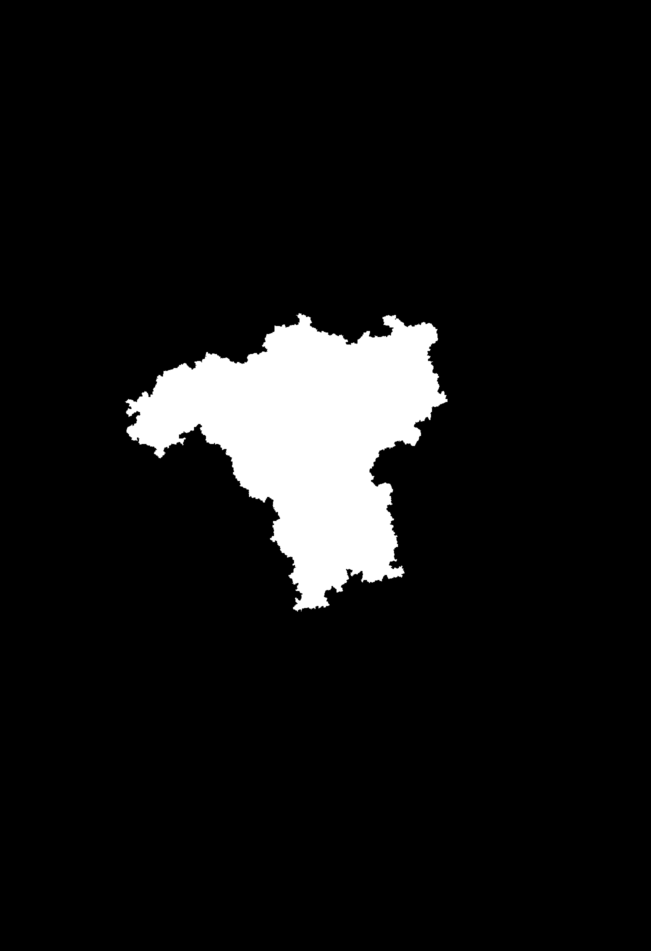

In [19]:
Gray.(d16s1_longlived_maps[:,:,14].==longlived_labels_1[3])

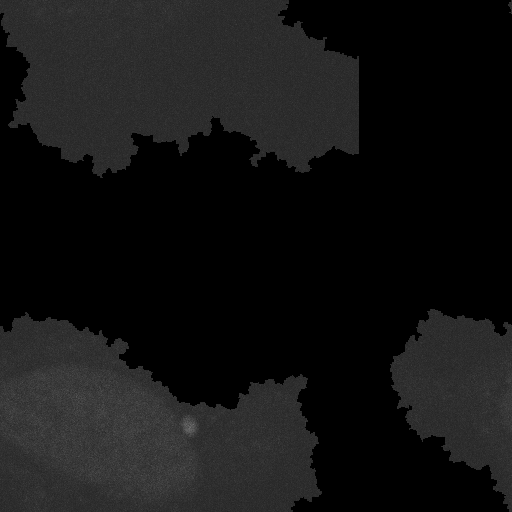

In [20]:
Gray.(cell_2[:,:,14].*100) 

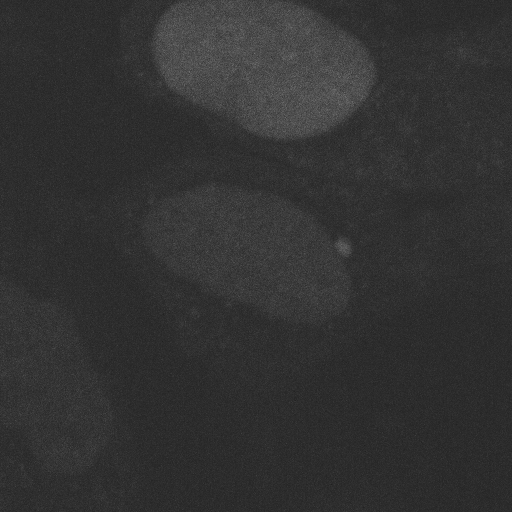

In [16]:
Gray.(d16s1[692:1203, 358:869, 14].*100)

In [25]:
[Gray.(cell_1[128:end-128,128:end-128,14].*100)  Gray.(cell_1[128:end-128,128:end-128,14].*(imfilter(cell_1[128:end-128,128:end-128, 15], Kernel.gaussian((2,2))).>yen_).*100)]

UndefVarError: UndefVarError: yen_ not defined

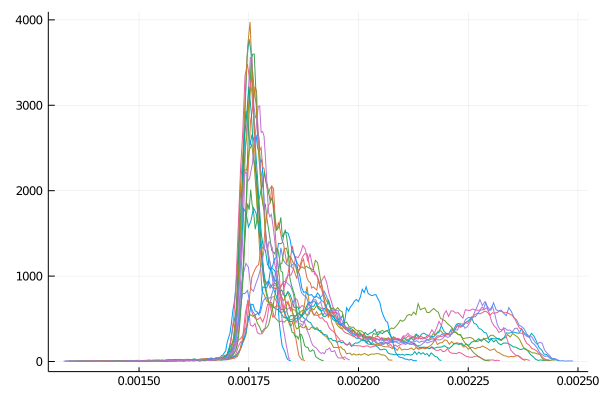

In [178]:
#img_gs = imfilter(cell_1[128:end-128,128:end-128, 13:14], Kernel.gaussian((2,2,1)))
plot(leg=false, lw=4)
yen = []
for i in 1:20
    img_gs = imfilter(cell_1[128:end-128,128:end-128, i], Kernel.gaussian((4,4)))
    edge, count = build_histogram( img_gs[img_gs.>0.001] )
    push!(yen, otsu_threshold(img_gs[img_gs .> 0.001]) )
    plot!(edge[100:end], count[100:end])
    #plot!([yen, yen],  [0, 6000])
end
plot!()

In [26]:
#img_gs = imfilter(cell_1[128:end-128,128:end-128, 13:14], Kernel.gaussian((2,2,1)))
plot(leg=false, lw=4)
yen = []
for i in 1:20
    img_gs = imfilter(cell_1[128:end-128,128:end-128, i], Kernel.gaussian((4,4)))
    edge, count = build_histogram( img_gs[img_gs.>0.001] )
    push!(yen, otsu_threshold(img_gs[img_gs .> 0.001]) )
    plot!(edge[100:end], count[100:end])
    #plot!([yen, yen],  [0, 6000])
end
plot!()

ArgumentError: ArgumentError: collection must be non-empty

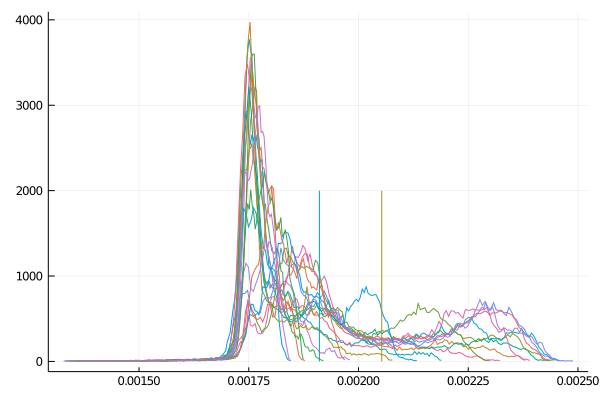

In [180]:
yen_ = median(yen)
plot!([yen_, yen_], [0, 2000])

In [182]:
@time d16s1_1_nu, d16s1_1_th = extract3dnucleus(cell_1);
@time save("d16s1_1_otsu.tiff", N0f16.(d16s1_1_nu));
embedxml(512, 512, 20, 138, "d16s1_1_otsu_gs.tiff")

Extracting nucleus


TaskFailedException: TaskFailedException:
InterruptException:
Stacktrace:
 [1] Array at ./boot.jl:409 [inlined]
 [2] Array at ./boot.jl:416 [inlined]
 [3] Array at ./boot.jl:422 [inlined]
 [4] similar at ./abstractarray.jl:671 [inlined]
 [5] similar at ./abstractarray.jl:670 [inlined]
 [6] similar at ./broadcast.jl:196 [inlined]
 [7] copy at ./broadcast.jl:840 [inlined]
 [8] materialize at ./broadcast.jl:820 [inlined]
 [9] macro expansion at /datahub/rawdata/tandeng/mRNA_imaging/CoutingmRNA.jl/segmentation3d.jl:34 [inlined]
 [10] (::var"#81#threadsfor_fun#6"{Array{Float64,3},Array{Float64,3},Array{Float64,1},UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:61
 [11] (::var"#81#threadsfor_fun#6"{Array{Float64,3},Array{Float64,3},Array{Float64,1},UnitRange{Int64}})() at ./threadingconstructs.jl:28